In [52]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import os
import zipfile
import shutil
import splitfolders
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten,Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import os
import zipfile
import shutil
import splitfolders
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout, SpatialDropout2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

In [29]:
data_dir = 'C:/Users/aidia/Downloads/dataset'
output = 'C:/Users/aidia/Downloads/chest_split'
splitfolders.ratio(data_dir, output=output, seed=1337, ratio=(0.75, 0.24, 0.01))

Copying files: 13810 files [02:02, 112.61 files/s]


In [70]:
base_dir = 'C:/Users/aidia/Downloads/chest_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [71]:
# gather train dataset
trainX = []
trainY = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            trainX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            trainY.append(label)

trainX = np.array(trainX)
trainY = np.array(trainY)

In [72]:
# gather validation data
valX = []
valY = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            valX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            valY.append(label)

valX = np.array(valX)
valY = np.array(valY)

In [73]:
# gather test data
testX = []
testY = []
for r, d, f in os.walk(test_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            testX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            testY.append(label)

testX = np.array(testX)
testY = np.array(testY)

In [74]:
# check shape of each images in train & test dataset
print("Train Data=", trainX.shape)
print("Train Label=", trainY.shape)
print("Validation Data=", valX.shape)
print("Validation Label=", valY.shape)
print("Test Data=", testX.shape)
print("Test Label=", testY.shape)

Train Data= (10356, 150, 150, 3)
Train Label= (10356,)
Validation Data= (4143, 150, 150, 3)
Validation Label= (4143,)
Test Data= (139, 150, 150, 3)
Test Label= (139,)


In [77]:
mask_train_path = 'C:/Users/aidia/Downloads/chest_split/train/Normal'
nomask_train_pat = 'C:/Users/aidia/Downloads/chest_split/train/COVID'
mask_val_path = 'C:/Users/aidia/Downloads/chest_split/val/Normal'
nomask_val_path = 'C:/Users/aidia/Downloads/chest_split/val/COVID'
mask_test_path = 'C:/Users/aidia/Downloads/chest_split/test/Normal'
nomask_test_path = 'C:/Users/aidia/Downloads/chest_split/test/COVID'

mask_len_train = len(os.listdir(mask_train_path))
nomask_len_train = len(os.listdir(nomask_train_pat))
mask_len_val = len(os.listdir(mask_val_path))
nomask_len_val = len(os.listdir(nomask_val_path))
mask_len_test = len(os.listdir(mask_test_path))
nomask_len_test = len(os.listdir(nomask_test_path))

print("jumlah dataset Training : ", mask_len_train + nomask_len_train)
print("jumlah dataset Validasi : ", mask_len_val + nomask_len_val)
print("jumlah dataset Test     : ", mask_len_test + nomask_len_test)
print("jumlah total Dataset    : ", mask_len_train + nomask_len_train + mask_len_val + nomask_len_val + mask_len_test + nomask_len_test)
print("\n\n")
print("jumlah train kelas Mask : ", mask_len_train)
print("jumlah train kelas No Mask : ", nomask_len_train)
print("jumlah validasi kelas Mask : ", mask_len_val)
print("jumlah validasi kelas No Mask : ", nomask_len_val)
print("jumlah test kelas Mask : ", mask_len_test)
print("jumlah test kelas No Mask : ", nomask_len_test)

jumlah dataset Training :  10356
jumlah dataset Validasi :  4143
jumlah dataset Test     :  139
jumlah total Dataset    :  14638



jumlah train kelas Mask :  7644
jumlah train kelas No Mask :  2712
jumlah validasi kelas Mask :  3058
jumlah validasi kelas No Mask :  1085
jumlah test kelas Mask :  102
jumlah test kelas No Mask :  37


In [78]:

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 10356 images belonging to 2 classes.
Found 4143 images belonging to 2 classes.


In [79]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
def exponential_decay(lr0, s):
     def exponential_decay_fn(epoch):
         return lr0 * 0.1 **(epoch / s)
     return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = LearningRateScheduler(exponential_decay_fn)

In [57]:
#optimizer
tagetdir = 'C:/Users/aidia/Downloads/Modul4_model1.h5'
savedir = tagetdir
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
best_model = ModelCheckpoint(savedir, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [80]:

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
]

In [108]:
from tensorflow.keras.optimizers import Adamax
import tensorflow as tf
# compile model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=METRICS)

In [82]:

# build a simple model
model = Sequential()

model.add(InputLayer(input_shape=[150, 150, 3]))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))


model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1,activation="sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 conv2d_22 (Conv2D)          (None, 70, 70, 128)       147584    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 35, 35, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 33, 33, 256)      

In [90]:
# training & saving history of every epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,  # images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=37,  #  images = batch_size * steps
      callbacks = [callbacks, best_model,lr_scheduler])

C:\Users\aidia\AppData\Local\Temp\ipykernel_15372\4091711473.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7190 - precision: 0.7783 - recall: 0.8659
Epoch 1: val_accuracy did not improve from 0.77838
50/50 [==============================] - 79s 2s/step - loss: 0.6179 - accuracy: 0.7190 - precision: 0.7783 - recall: 0.8659 - val_loss: 11.2508 - val_accuracy: 0.7095 - val_precision: 0.7095 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7230 - precision: 0.7915 - recall: 0.8522
Epoch 2: val_accuracy did not improve from 0.77838
50/50 [==============================] - 80s 2s/step - loss: 0.6340 - accuracy: 0.7230 - precision: 0.7915 - recall: 0.8522 - val_loss: 2.8822 - val_accuracy: 0.7243 - val_precision: 0.7240 - val_recall: 1.0000 - lr: 0.0089
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.7060 - precision: 0.7641 - recall: 0.8609
Epoch 3: val_accuracy did not improve from 0.77838
50/50

Model 1

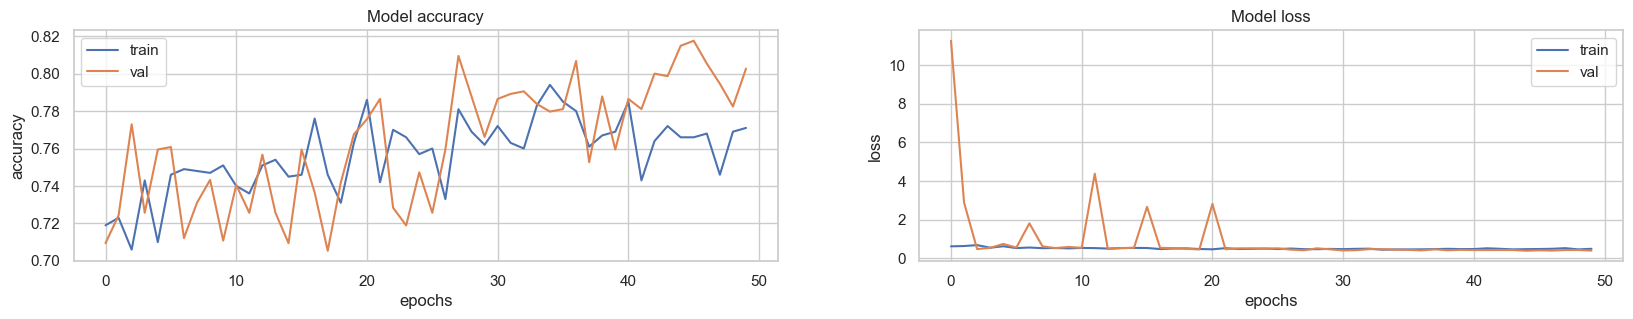

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
     

Model 2

In [102]:
tagetdir = 'C:/Users/aidia/Downloads/Modul4_model2.h5'
savedir = tagetdir
callbacks = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')        
best_model = ModelCheckpoint(savedir, monitor='val_accuracy', verbose = 1, save_best_only = True)

In [106]:
# build a simple model
model = Sequential()

model.add(InputLayer(input_shape=[150, 150, 3]))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))
model.add(Flatten())

model.add(Dense(units=256,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=512,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1,activation="sigmoid"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 70, 70, 128)       147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 35, 35, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 33, 33, 128)      

In [109]:

# training & saving history of every epoch
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,  # images = batch_size * steps
      epochs=50,
      validation_data=validation_generator,
      validation_steps=37,  #  images = batch_size * steps
      callbacks = [callbacks, best_model,lr_scheduler])

C:\Users\aidia\AppData\Local\Temp\ipykernel_15372\1837023311.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 1.2981 - accuracy: 0.6120 - precision: 0.7606 - recall: 0.8273
Epoch 1: val_accuracy improved from -inf to 0.25676, saving model to C:/Users/aidia/Downloads\Modul4_model2.h5
50/50 [==============================] - 75s 1s/step - loss: 1.2981 - accuracy: 0.6120 - precision: 0.7606 - recall: 0.8273 - val_loss: 156.7123 - val_accuracy: 0.2568 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 0.7321 - accuracy: 0.6640 - precision: 0.7500 - recall: 0.8189
Epoch 2: val_accuracy improved from 0.25676 to 0.64595, saving model to C:/Users/aidia/Downloads\Modul4_model2.h5
50/50 [==============================] - 70s 1s/step - loss: 0.7321 - accuracy: 0.6640 - precision: 0.7500 - recall: 0.8189 - val_loss: 56.4657 - val_accuracy: 0.6459 - val_precision: 0.7967 - val_recall: 0.7076 - lr: 0.0089
Epoch 3/50
50/50 [==============================] - ET